In [1]:
import shutil
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tflayers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
# import Augmentor

In [2]:
!git clone https://github.com/Compfest-AIdea/machine-learning.git

Cloning into 'machine-learning'...
remote: Enumerating objects: 6164, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 6164 (delta 55), reused 116 (delta 31), pack-reused 6007
Receiving objects: 100% (6164/6164), 98.68 MiB | 32.96 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (6529/6529), done.


# Data Splitting

In [3]:
IMAGE_SIZE = 150
BATCH_SIZE = 256

train_dir = "/content/machine-learning/Dataset/Dataset-Image-Augmented/train"
validation_dir = "/content/machine-learning/Dataset/Dataset-Image-Augmented/validation"
TRAINING_DIR = train_dir
VALIDATION_DIR = validation_dir

training_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 3600 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.


# Model Development

In [4]:
class StopperCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.88 and logs.get('val_accuracy') >= 0.88:
            print("\nTraining is stopped because both training and validation accuracy reached 88%.")
            self.model.stop_training = True

In [6]:
#Percobaan 2 : Pake Model ResNet10V2

from tensorflow.keras.applications import resnet_v2

base_model = resnet_v2.ResNet101V2(include_top=False,
                                  weights='imagenet',
                                  input_shape=(150,150,3))

for layers in base_model.layers:
  layers.trainable=False

base_model.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                     

In [7]:
from tensorflow.keras import Model

base_output = base_model.output
x = tflayers.Flatten()(base_output)
x = tflayers.Dense(32,activation='relu')(x)
x = tflayers.Dropout(0.5)(x)
output_layer = tflayers.Dense(5,activation='softmax')(x)

model = Model(inputs = base_model.inputs, outputs = output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                              

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
# val_acc_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#     min_delta=0.005,
#     patience=10,
#     verbose=1,
#     mode='max',
#     baseline=None,
#     restore_best_weights=True,
#     start_from_epoch=0)

In [9]:
stopper_callback = StopperCallback()


history = model.fit(
    train_generator,
    epochs=145,
    verbose=1,
    validation_data = validation_generator,
    callbacks = [stopper_callback]#, scheduler_callback]
)

Epoch 1/145
15/15 [==============================] - 38s 1s/step - loss: 1.4347 - accuracy: 0.4842 - val_loss: 0.8765 - val_accuracy: 0.6267
Epoch 2/145
15/15 [==============================] - 11s 742ms/step - loss: 0.9826 - accuracy: 0.5767 - val_loss: 0.8132 - val_accuracy: 0.6908
Epoch 3/145
15/15 [==============================] - 12s 756ms/step - loss: 0.8434 - accuracy: 0.6469 - val_loss: 0.6628 - val_accuracy: 0.7533
Epoch 4/145
15/15 [==============================] - 12s 773ms/step - loss: 0.7550 - accuracy: 0.6675 - val_loss: 0.6016 - val_accuracy: 0.7908
Epoch 5/145
15/15 [==============================] - 12s 777ms/step - loss: 0.6725 - accuracy: 0.7308 - val_loss: 0.5151 - val_accuracy: 0.8250
Epoch 6/145
15/15 [==============================] - 14s 901ms/step - loss: 0.6273 - accuracy: 0.7439 - val_loss: 0.5346 - val_accuracy: 0.8317
Epoch 7/145
15/15 [==============================] - 12s 778ms/step - loss: 0.6112 - accuracy: 0.7667 - val_loss: 0.4778 - val_accuracy: 0.

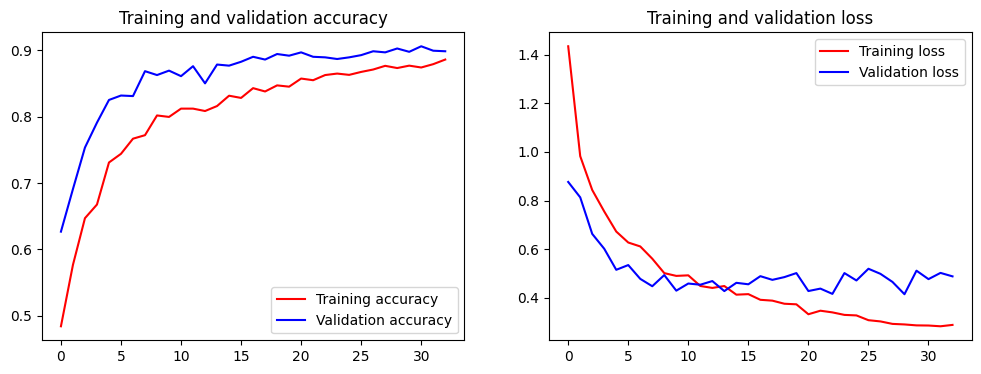

In [10]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [11]:
model.save('scalp_model_resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import tensorflow as tf

# Load the Keras model
scalp_model_resnet = tf.keras.models.load_model('/content/scalp_model_resnet.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(scalp_model_resnet)
tflite_scalp_model_resnet = converter.convert()

# Save the TensorFlow Lite model
with open('scalp_model_resnet.tflite', 'wb') as f:
    f.write(tflite_scalp_model_resnet)

In [15]:
import os

# Ganti path ke lokasi file .ftlite Anda
file_path = '/content/scalp_model_resnet.tflite'

# Mengecek apakah file ada
if os.path.exists(file_path):
    # Mendapatkan ukuran file dalam byte
    file_size = os.path.getsize(file_path)

    # Menghitung ukuran dalam KB, MB, atau GB tergantung pada ukurannya
    if file_size < 1024:
        size_str = f"{file_size} B"
    elif file_size < 1024 * 1024:
        size_str = f"{file_size / 1024:.2f} KB"
    elif file_size < 1024 * 1024 * 1024:
        size_str = f"{file_size / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{file_size / (1024 * 1024 * 1024):.2f} GB"

    print(f"Ukuran file {file_path}: {size_str}")
else:
    print(f"File '{file_path}' tidak ditemukan.")


Ukuran file /content/scalp_model_resnet.tflite: 168.51 MB


## Inception

In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model_inception = InceptionV3(include_top=False,
                                   weights='imagenet',
                                   input_shape=(150,150,3),
                                   )
for layers in base_model_inception.layers:
  layers.trainable=False

base_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 74, 74, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

In [29]:
base_output = base_model_inception.output

x = tflayers.Flatten()(base_output)
x = tflayers.Dense(512,activation='relu')(x)
x = tflayers.Dropout(0.5)(x)
model_output = tflayers.Dense(5,activation='softmax')(x)

model_inception = Model(inputs = base_model_inception.input, outputs = model_output)
model_inception.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 74, 74, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 74, 74, 32)           0         ['batch_normalization_18

In [30]:
model_inception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
stopper_callback = StopperCallback()


history = model_inception.fit(
    train_generator,
    epochs=145,
    verbose=1,
    validation_data = validation_generator,
    callbacks = [stopper_callback]#, scheduler_callback]
)

Epoch 1/145
15/15 [==============================] - 21s 990ms/step - loss: 10.7000 - accuracy: 0.3928 - val_loss: 2.2112 - val_accuracy: 0.6475
Epoch 2/145
15/15 [==============================] - 12s 780ms/step - loss: 1.2510 - accuracy: 0.6603 - val_loss: 0.7785 - val_accuracy: 0.7617
Epoch 3/145
15/15 [==============================] - 9s 559ms/step - loss: 0.7012 - accuracy: 0.7567 - val_loss: 0.6121 - val_accuracy: 0.7858
Epoch 4/145
15/15 [==============================] - 9s 607ms/step - loss: 0.5839 - accuracy: 0.7892 - val_loss: 0.4938 - val_accuracy: 0.8208
Epoch 5/145
15/15 [==============================] - 9s 605ms/step - loss: 0.4465 - accuracy: 0.8369 - val_loss: 0.4190 - val_accuracy: 0.8558
Epoch 6/145
15/15 [==============================] - 9s 633ms/step - loss: 0.3712 - accuracy: 0.8658 - val_loss: 0.3973 - val_accuracy: 0.8592
Epoch 7/145
15/15 [==============================] - 9s 621ms/step - loss: 0.3452 - accuracy: 0.8767 - val_loss: 0.3593 - val_accuracy: 0.8

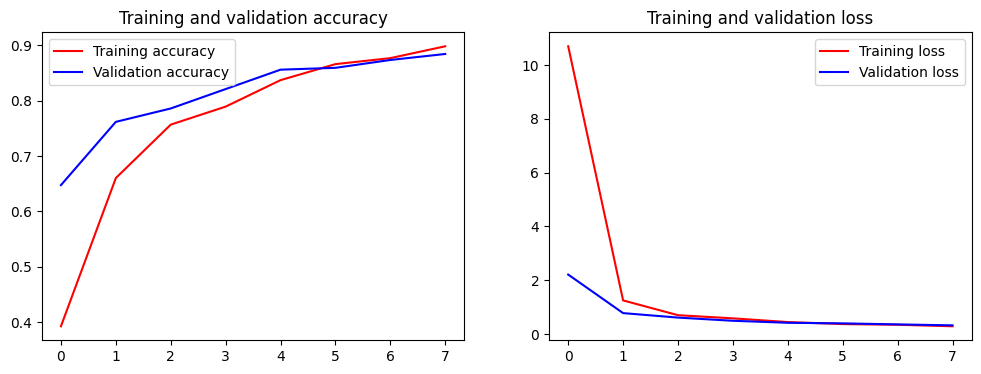

In [32]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [36]:
model_inception.save('scalp_model_inception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import tensorflow as tf

# Load the Keras model
scalp_model_inception = tf.keras.models.load_model('/content/scalp_model_inception.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(scalp_model_inception)
tflite_scalp_model_inception= converter.convert()

# Save the TensorFlow Lite model
with open('scalp_model_inception.tflite', 'wb') as f:
    f.write(tflite_scalp_model_inception)

In [38]:
import os

# Ganti path ke lokasi file .ftlite Anda
file_path = '/content/scalp_model_inception.tflite'

# Mengecek apakah file ada
if os.path.exists(file_path):
    # Mendapatkan ukuran file dalam byte
    file_size = os.path.getsize(file_path)

    # Menghitung ukuran dalam KB, MB, atau GB tergantung pada ukurannya
    if file_size < 1024:
        size_str = f"{file_size} B"
    elif file_size < 1024 * 1024:
        size_str = f"{file_size / 1024:.2f} KB"
    elif file_size < 1024 * 1024 * 1024:
        size_str = f"{file_size / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{file_size / (1024 * 1024 * 1024):.2f} GB"

    print(f"Ukuran file {file_path}: {size_str}")
else:
    print(f"File '{file_path}' tidak ditemukan.")


Ukuran file /content/scalp_model_inception.tflite: 119.10 MB
